# Real Python GAN Example

Found here: https://realpython.com/generative-adversarial-networks/

## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn


# Manually set random seed for reproducability
torch.manual_seed(111)


## Sine Wave Generator

In [2]:
# Create empty training data set
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

# Set x1= random floats 0<x<2*pi (x axis)
# Set x2= sin(x1) (y axis)
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])

# Set labels to 0 (incorrect) - will not be used but required by pytorch
train_labels = torch.zeros(train_data_length)


train_set = [ (train_data[i], train_labels[i]) for i in range(train_data_length) ]


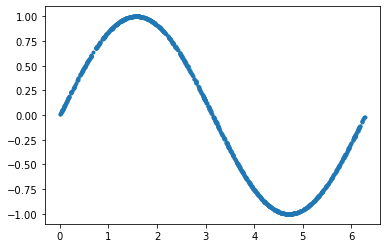

In [3]:
# Plot training data
plt.plot(train_data[:, 0], train_data[:, 1], ".")


In [4]:
# Create loader for training set
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


In [5]:
# Create discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), # Input will be a data point in the form of (x1, x2)
            nn.ReLU(),
            nn.Dropout(0.3), # Used to avoid overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1), # Output will be a probability that data point is from "correct" data set
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

# Instanitate the discriminator neural network
discriminator = Discriminator()


In [6]:
# Create generator class
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2), # Output will be a data point in the form of (~x1, ~x2)
        )

    def forward(self, x):
        output = self.model(x)
        return output

# Instantiate the generator neural network
generator = Generator()


### Training the Models

In [7]:
# 
lr = 0.001  # Learning rate
num_epochs = 300  # How many repetitions of the whole data set will be performed
loss_function = nn.BCELoss()


In [8]:
# Optimizers; Use the "Adam algorithm" 
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


In [9]:
# Training loop
for epoch in range(num_epochs):
    
    for n, (real_samples, _) in enumerate(train_loader):
        
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad() # In PyTorch, it’s necessary to clear the gradients at each training step to avoid accumulating them
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward() # Calculate the gradients to update the weights
        optimizer_discriminator.step() # Update the discriminator weights
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad() # Zero the gradients
        generated_samples = generator(latent_space_samples) # Generate samples
        output_discriminator_generated = discriminator(generated_samples) # Calculate discriminator output of generated samples
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


Epoch: 0 Loss D.: 0.15663038194179535
Epoch: 0 Loss G.: 2.1256043910980225
Epoch: 10 Loss D.: 0.6571138501167297
Epoch: 10 Loss G.: 0.8178414702415466
Epoch: 20 Loss D.: 0.6383628845214844
Epoch: 20 Loss G.: 0.9057260751724243
Epoch: 30 Loss D.: 0.59872967004776
Epoch: 30 Loss G.: 0.7265846729278564
Epoch: 40 Loss D.: 0.607196569442749
Epoch: 40 Loss G.: 0.747387707233429
Epoch: 50 Loss D.: 0.6520012617111206
Epoch: 50 Loss G.: 0.8308240175247192
Epoch: 60 Loss D.: 0.69268399477005
Epoch: 60 Loss G.: 0.7017871737480164
Epoch: 70 Loss D.: 0.7220638990402222
Epoch: 70 Loss G.: 0.7281138896942139
Epoch: 80 Loss D.: 0.6826226711273193
Epoch: 80 Loss G.: 0.6805168986320496
Epoch: 90 Loss D.: 0.6530492305755615
Epoch: 90 Loss G.: 0.7535091638565063
Epoch: 100 Loss D.: 0.6849632263183594
Epoch: 100 Loss G.: 0.7417536973953247
Epoch: 110 Loss D.: 0.6993071436882019
Epoch: 110 Loss G.: 0.6938921809196472
Epoch: 120 Loss D.: 0.6608849763870239
Epoch: 120 Loss G.: 0.7120289206504822
Epoch: 130 Lo

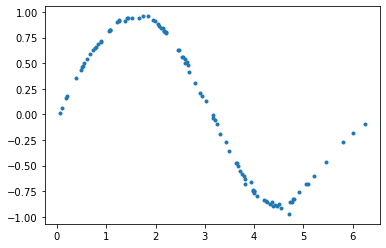

In [10]:
# Generate some data points
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

# Plot them
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")


## Handwritten Number Generator

In [11]:
# Configure environment
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [12]:
# transforms.ToTensor() converts the data to a PyTorch tensor.
# transforms.Normalize() converts the range of the tensor coefficients.

# Function to transform images to training data set
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Download training set
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

# Create data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)


100.1%

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0.0%

2.5%5%

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


100.4%

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


180.4%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


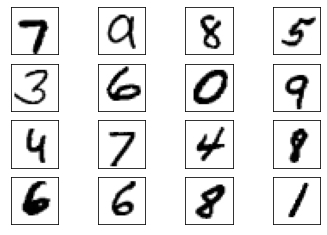

In [14]:
# Plot some of the training data
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


In [ ]:
# Create discriminator class 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)


In [ ]:
# Create generator class
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # output coefficients should be in the interval from -1 to 1
        )
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)


In [ ]:
# 
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)


### Training the models

In [ ]:
# Training loop
for epoch in range(num_epochs):
    
    for n, (real_samples, mnist_labels) in enumerate(train_loader):\
        
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


In [ ]:
# Generate samples
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

# Plot them
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
